# Exponential Integrators for Stiff Systems

*Numerical Methods II (Spring 2018) Final Project Presentation*

Group members

- Xingjian Guo (*xg703@nyu.edu*)

- Shuidie Yao (*sy2328@nyu.edu*)

- Hui Duan (*hd1021@nyu.edu*)

Main reference: Hochbruck, M., Lubich, C., & Selhofer, H. (1998). Exponential integrators for large systems of differential equations. SIAM Journal on Scientific Computing, 19(5), 1552-1574.

# 1. Motivation

**Stiff problems**: explicit methods performs badly.

For example, the linear equation

$$ u'(t) = Lu(t) $$
  
- Stiffness: $L$ has large negative/imaginary eigenvalues.
  
- Forward Euler, RK4, etc requires very small $dt$.

- Solution: use implicit methods (require solving equations each step).

Exponential integrators: modify the explicit methods to handle the stiffness.

- For a linear system, analytic solution is known: $u(t) = e^{tL}u(0)$.

- What about nonlinear equations?

# 2. Derivation of the schemes

Consider the **semilinear** ODE:

$$ u'(t) = f(t,u) = Lu(t) + N(t,u) $$
  
- General $f$: $L$ is the Jacobian

ODE → **Volterra integral equation**

$$ u(t) = e^{tL}u(0) + \int_0^te^{(t - \tau)L}N(\tau, u(\tau))d\tau $$
  
- Approximation to the integral → exponential integrators

First order: $N(\tau,u(\tau)) = N(0,u(0))$ → **Norsett-Euler** scheme

  $$ u_{n+1} = e^{hL}u_n + \frac{e^{hL} - I}{L}N(t_n,u_n) $$

General $s$-stage expRK methods:

- $c_1 = 0, 0 < c_2,c_3,\ldots,c_s \le 1$

- At stage $i$:

  $$ U_{ni} = e^{c_ihL}u(0) + h\sum_{j=1}^{i-1}a_{ij}(hL)N_{nj},\quad N_{ni} = N(t_n + c_ih, U_{ni}) $$
  
- Update:

  $$u_{n+1} = e^{hL}u(0) + h\sum_{j=1}^sb_j(hL)N_{nj}$$

Small $L$ limit: should reduce to a corresponding RK method

- Norsett-Euler (1st order) → Forward Euler

- Exponential midpoint (2nd order) → Explicit midpoint

- Exponential Trapezoid (2nd order) → Explicit Trapezoid (Heun's method)

- ETDRK4 (4th order) → RK4

**Technical details**

1. The matrix functions $e^{hL}$, $a_{ij}(hL)$ and $b_j(hL)$

  - Small system: rational approximations (Pade)
  
  - Large system: Krylov methods
  
2. Numerical stability issue for small $h$

  - Cancellation error: e.g. $(e^z - 1)/z$

# 3. The `Expint.py` package

Target: semilinear ODE $ u'(t) = Lu(t) + N(t,u) $

Integrators:

- `LawsonEuler` & `ExpEuler`: 1st order

- `ExpMidpoint` & `ExpTrapezoid`: 2nd order

- `ETDRK4`: 4th order

- `RK4`: for comparison

Similar interface to `scipy.integrate`

- Light weight: `solve_semilinear` (like `solve_ivp`)

- Fine tuning: `SemilinearODESolver` (like `ODESolver`)

In [1]:
# Load the package
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
from expint import *
from RK import RK4

# Test order of convergence on test system
methods = [LawsonEuler, NorsettEuler, ExpMidpoint, ExpTrapezoid, ETDRK4]
m = 5 # dimension
y0 = np.random.rand(m) - 0.5
t_span = (0.0, 2.0); dt = 1e-5

# Construct L and N
np.random.seed(20180504)
L = np.random.rand(m,m) - 0.5
N = lambda t, y: np.sin(t)*y**2

# Get reference solution using RK4
yref = solve_semilinear(L, N, t_span, y0, dt, method=RK4)[1][-1,:]

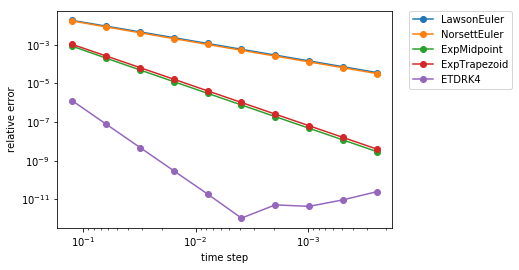

In [2]:
# Plot solution errors using expRK methods
dts = np.logspace(-3, -12, num=10, base=2.0)
for method in methods:
    errs = np.zeros(len(dts))
    for i in range(len(dts)):
        y = solve_semilinear(L, N, t_span, y0, dts[i], method)[1][-1,:]
        errs[i] = la.norm(y - yref) / la.norm(yref)
    plt.plot(dts, errs, '-o', label=method.__name__)
plt.xlabel('time step')
plt.ylabel('relative error')
plt.loglog()
plt.xlim(plt.xlim()[1], plt.xlim()[0]) # revert x axis
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# 4. Example: the Allen-Cahn equation

$$ \partial_tu = D\Delta u + u - u^3 $$

- One dimension, finite difference.

- Explicit methods: $\Delta t \sim \Delta x^2$.

- ExpRK: can take large $\Delta t$ even for a very fine grid.

In [3]:
from ac import AllenCahn
m = 999 # number of internal nodes
R = 20.0 # domain length
D = 0.1 # diffusion coefficient
t_span = (0.0, 10.0)
L, N, X = AllenCahn(m, R, D)

# Construct initial data (two pulses)
y0 = np.zeros(m)
y0[m//4] = 1.0; y0[m*3//4] = -1.0

In [4]:
def solve_and_plot(dt, method):
    _, ys = solve_semilinear(L, N, t_span, y0, dt, method)
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot(X, ys[0,:])
    plt.xlabel('x'); plt.ylabel('u')
    plt.title("{}, dt = {}, T = 0.0".format(method.__name__, dt))
    
    plt.subplot(1,2,2)
    plt.plot(X, ys[-1,:])
    plt.xlabel('x'); plt.ylabel('u')
    plt.title("{}, dt = {}, T = 10.0".format(method.__name__, dt))

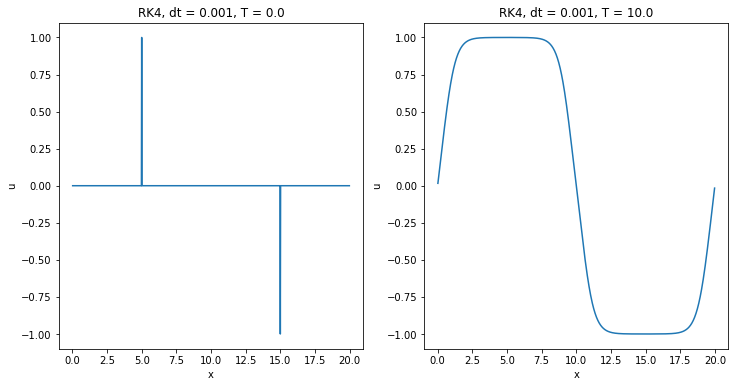

In [5]:
# The RK4 method can only handle small dt
solve_and_plot(dt=1e-3, method=RK4)

C:\Users\MSeeker\Desktop\Num2\num2-spring2018\src\ac.py:19: RuntimeWarning: overflow encountered in power
  N = lambda t, u: -u**3


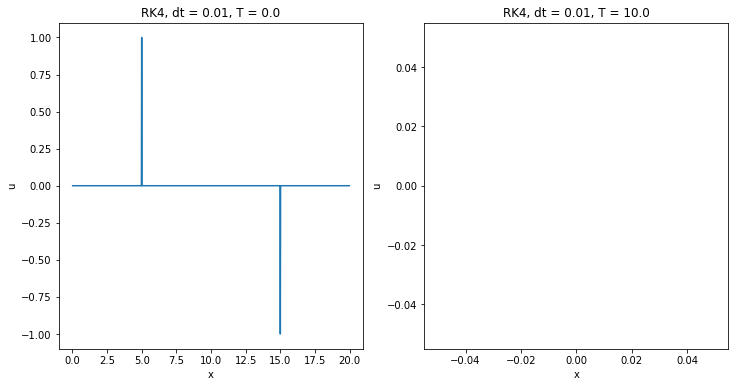

In [6]:
solve_and_plot(dt=1e-2, method=RK4)

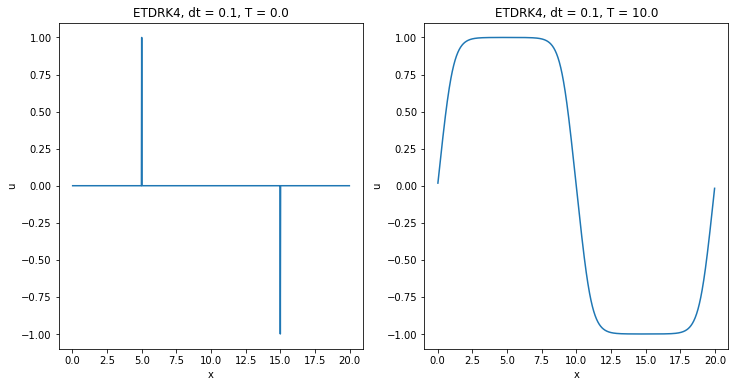

In [7]:
# ETDRK4 is stable for large time steps
solve_and_plot(dt=0.1, method=ETDRK4)

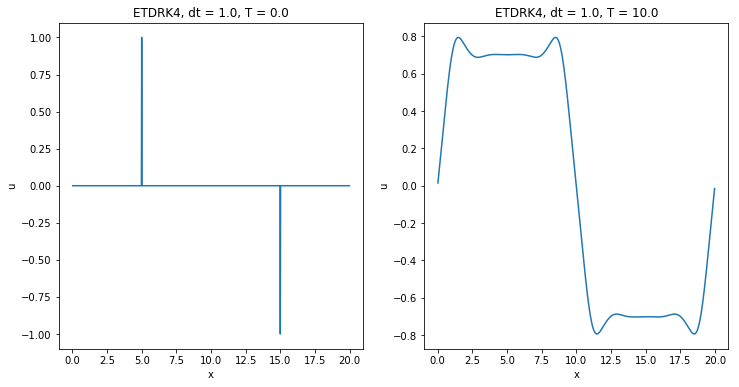

In [8]:
solve_and_plot(1.0, ETDRK4) # inaccurate but still stable